In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import math
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import ecg
import BP_func




def quality_inspection(filt_ppg, sr, pulse_loc, template_length=None, xcorr_thr=0.8):
    num_pulse = len(pulse_loc)
    hq_idx = np.zeros(num_pulse)
    r = np.zeros(num_pulse)
    duration = np.zeros(num_pulse)
    for n in range(num_pulse):
        tr1_loc = pulse_loc[n][0]
        tr2_loc = pulse_loc[n][2]
        duration[n] = tr2_loc- tr1_loc
    
    # Dynamic set the length of template
    if template_length == None:
        template_length = int(np.median(duration))
        max_len = 180/60 # minimum HR 240
        min_len = 50/60 # minimum HR 40
        if template_length > sr*max_len:
            template_length = int(sr*max_len)
        elif template_length < sr*min_len:
            template_length = int(sr*min_len)
    
        # Template Initial
        for n in range(num_pulse):
            single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)        
            if n == 0:
                ref_pulse = single_pulse
            else:
                test_pulse = single_pulse
            
                # Pulse similarity inspection using cross correlation 
                xcorr = sp.corrcoef(test_pulse, ref_pulse)
                r[n] = np.round(xcorr,2)
                # Store the index of good quality pulse
                if xcorr > xcorr_thr:
                    hq_idx[n] = 1
                    
                # update previous pulse
                ref_pulse = test_pulse   

    # Setting template length by the reference, trim the pulse into proper length
    else: 
        tol = 5 # BPM
        for n in range(num_pulse):
            # single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)
            pulse_hr = 60*(sr/(pulse_loc[n][2] - pulse_loc[n][0]))
            template_hr = 60*(sr/template_length)
            diff_bpm = abs(pulse_hr - template_hr)
            # trim_start = pulse_loc[n][0]
            # trim_end = trim_start + template_length
            # single_pulse = filt_ppg[trim_start:trim_end]
            single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)        

            
            if n == 0:
                ref_pulse = single_pulse
            else:
                test_pulse = single_pulse
                
                # Pulse similarity inspection using cross correlation 
                xcorr = sp.corrcoef(test_pulse, ref_pulse)
                r[n] = np.round(xcorr,2)
                # Store the index of good quality pulse
                if xcorr > xcorr_thr and diff_bpm <tol:
                    hq_idx[n] = 1
                # plt.figure(figsize=(4,3))
                # plt.title('xcorr:{}'.format(xcorr))
                # plt.plot(ref_pulse, label='ref pulse')
                # plt.plot(test_pulse, label='test pulse')
                # plt.legend()
                
                # update previous pulse
                ref_pulse = test_pulse   
    return hq_idx, r

def local_max(data, peak_loc, w=8):
    peak_loc_len = len(peak_loc)
    modify_peak = np.zeros(peak_loc_len)
    for i in range(len(peak_loc)):
        loc = peak_loc[i]
        left_pt= max(0, loc-w)
        right_pt = min(len(data), loc+w)
        modify_peak[i] = left_pt + np.argmax(data[left_pt: right_pt])
    modify_peak = [int(v) for v in modify_peak]
    return modify_peak



def BP_calc(feat1, feat2):
    
    # BP_PARAMS= [104.3803, 0.264739, 45.49831, -0.48552, 0.331942, 46.86839]
    #FW version
    BP_PARAMS = [104.3803, 0.264739, 45.49831, -0.48552, 0.331942, 46.86839]
    # feature 1 indicate ratio of diostole
    # feature 2 indicate hr
    sbp = BP_PARAMS[0] * feat1 + BP_PARAMS[1] * feat2 + BP_PARAMS[2]
    dbp = BP_PARAMS[3] * feat1 + BP_PARAMS[4] * feat2 + BP_PARAMS[5]
    sbp=int(sbp+0.5)
    dbp=int(dbp+0.5)
    return sbp, dbp


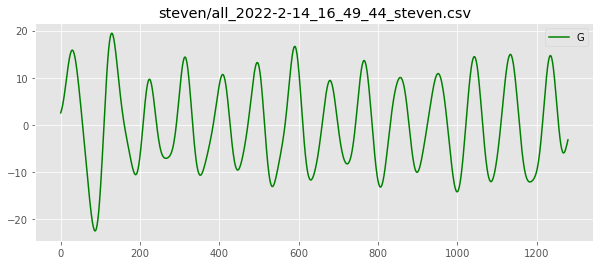

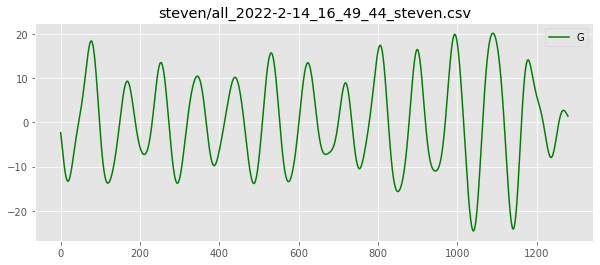

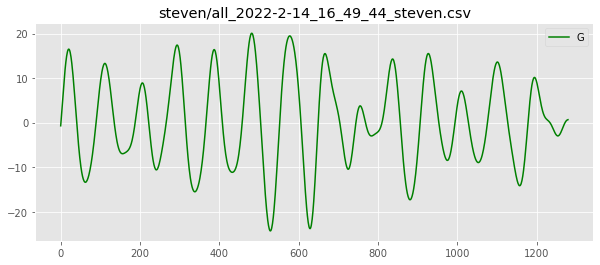

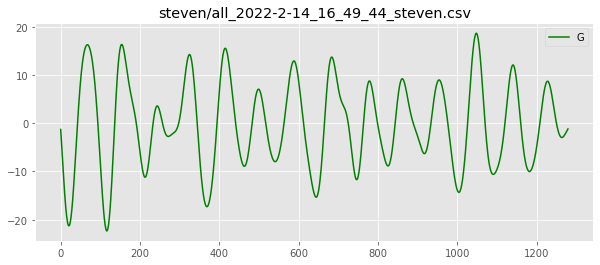

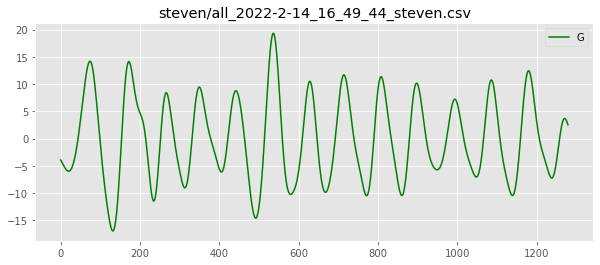

In [10]:


#new format, all data in one package
# folder = 'test/new_format'
# subjects = ['rick']

folder = 'BP'
# subjects = ["Shawn_all_2022-4-26_16_53_38.csv", "Steven_all_2022-4-26_16_54_51.csv"]
subjects = ["steven/all_2022-2-14_16_49_44_steven.csv"]
# folder = 'test/spo2'
# subjects = ['rick', 'steven', 'shawn']

'''overall parameters '''

sr = 128
window = sr*10

# Filter parameters
b, a = sp.bp_filter(0.8, 3, sr, 4)

LEDS= ['G', 'R', 'IR']
vital_sign={
    'subject':[],
    'HR':[],
    'PHR':[],
    'Dt':[],
    'sbp':[],
    'dbp':[]
}

for subject in subjects:
    file_name = subject
    full_file_path = os.path.join("../../data", 'stark', folder, file_name)
    data = file_read.stark_reader(full_file_path)
    # ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    # ecg_data= file_read.csv_reader(full_file_path, 'ecg') 
    
    start_sec = 2
    step_sec = 4
    end_sec = 20

    for start_sec in range(start_sec, end_sec, step_sec):
        
        s1 = start_sec*sr
        s2 = s1+window 

        '''Read ECG '''
        ecg_sample = np.array(data['ecg'][s1:s2])
        filt_ecg = np.array(ecg.final_filter(ecg_sample, sr, 4))
        filt_ecg = sp.z_score(filt_ecg)
        ecg_proc = ecg.ecg_preprocess(ecg_sample, sr)
        ecg_proc = np.array(ecg_proc)
        ecg_hr_list, rpeak = ecg.ecg_hr_estimate(ecg_proc, sr)
        ecg_hr = np.round(np.mean(ecg_hr_list),2)
        
        rr = np.diff(rpeak)  # unit in seconds        

        ''' Read PPG '''
        ppg_IR = data['IR'][s1:s2]
        # ppg_IR = sp.flip_up_down(ppg_IR)
        ppg_R = data['R'][s1:s2]
        # ppg_R = sp.flip_up_down(ppg_R)
        ppg_G = data['G'][s1:s2]

        # ppg_IR = np.array(sp.flip_up_down(ppg_IR))
        filt_R = signal.filtfilt(b, a, ppg_R)
        filt_IR = signal.filtfilt(b, a, ppg_IR)
        filt_G = signal.filtfilt(b, a, ppg_G)

        R_pks_loc, R_trs_loc= sp.find_peak_valley(sr, filt_R)
        


        filt_ppg = (filt_IR+ filt_R)/2
        filt_ppg = sp.z_score(filt_ppg)
        
        '''BP features'''
        '''
        # return 7 ppg features [HR, alpha, St, Dt, Ih, Il, PIR]
        pks_loc, trs_loc= sp.find_peak_valley(sr, filt_ppg)
        pulse_loc = sp.pulse_seg(pks_loc, trs_loc)
        num_pulse = len(pulse_loc)
        
        template_length = int(np.mean(rr) + 0.5)
        hq_idx, relate= quality_inspection(filt_ppg, sr, pulse_loc, template_length, xcorr_thr=0.8)
        '''
        
        '''PPG features '''
        '''
        # tol = sr/bpm * 60
        tol = 5 # bpm
        quilify_list = np.zeros(num_pulse)
        Dt_list = []
        ppg_hr_list = []
        for n in range(num_pulse):
            nni = (pulse_loc[n][2] - pulse_loc[n][0])
            _hr = np.round((60*(sr/nni)), 2)
            # diff = nni-rr
            if hq_idx[n]==1:
                Dt = (pulse_loc[n][2] - pulse_loc[n][1])/sr
                
                Dt_list.append(Dt)
                ppg_hr_list.append(_hr)
                # print('ppg hr:{}, Dt:{}, ecg hr:{}'.format(_hr, Dt, ecg_hr))

        if Dt_list ==[]:    
            sbp = None
            dbp = None
            ppg_hr = None
            mean_Dt = None
        else:
            mean_Dt = np.round(np.mean(Dt_list), 2)
            sbp, dbp = BP_calc(mean_Dt, ecg_hr)
            ppg_hr = np.round(np.mean(ppg_hr_list),2)
            
        # ppg_features = BP_func.get_features(sr, filt_ppg)
        
        # print('Dt:{}, ecg hr:{}'.format(np.mean(Dt_list), ecg_hr))
        # print('sbp:{}, dbp:{}'.format(sbp, dbp))
        '''

        ''' PAT feature'''
        # PATp = []
        # for i in range(num_pulse):
        #     if hq_idx[i] == 1:
        #         min_dist = 999
        #         pk_loc= pulse_loc[i][1]
        #         for r in rpeak:
        #             if r > pk_loc and (r-pk_loc) < min_dist:
        #                 min_dist = r-pk_loc
        #         _tmp = min_dist /sr
        #         PATp.append(_tmp)
            
        # if PATp == []:
        #     pulse_arrival_time = None
        #     vital_sign['PATp'].append(None)
        # else:
        #     pulse_arrival_time = np.round(np.mean(PATp),3)
        #     vital_sign['PATp'].append(np.mean(PATp))
            
        
        '''Plot ecg '''
        # modify_rpeak = local_max(filt_ecg, rpeak, w=8)
        
        # plt.figure(figsize=(12,4))
        # plt.title(subject)
        # # plt.plot(filt_ecg, label='ECG')
        # # plt.plot(rpeak, filt_ecg[rpeak], '*')
        # for rp in rpeak:
        #     plt.axvline(rp, color='brown', ls='-.')
        
        
        
        '''Plot IR  '''

        
        plt.figure(figsize=(10,4))
        # plt.title(file_name +', ' +  str(start_sec) +':'+ str(start_sec+step_sec) + str(pulse_arrival_time))
        # # plt.title('{}, PAT:{}'.format(file_name, pulse_arrival_time))
        # plt.title('sbp:{}, dbp:{}, Dt:{}, ppg hr:{}, ecg hr:{},'.format(sbp, dbp, mean_Dt, ppg_hr, ecg_hr))
        plt.title(subject)
        # plt.plot(filt_R, label='R')
        # plt.plot(filt_IR, label='IR')
        plt.plot(filt_G, label='G', color='g')
        plt.legend()
        # plt.legend()
        # plt.plot(trs_loc, filt_ppg[trs_loc], '*', color='blue') # plot trough points

        # # plt.plot(pks_loc, filt_ppg[pks_loc], '*', color='r')
        # for j in range(num_pulse):
        #     pk_loc= pulse_loc[j][1]
        #     # if hq_idx[j] == 1 and tm_flag ==1:
        #     if hq_idx[j] ==1:
        #         # plot peak points on high-similarity consecutive pulses
        #         plt.plot(pk_loc, filt_ppg[pk_loc], color='green' , marker='*', markersize=14)
        #     else:
        #         plt.plot(pk_loc, filt_ppg[pk_loc], color='red' , marker='*')

        #     plt.text(pk_loc, filt_ppg[pk_loc], relate[j])

        
        # vital_sign['subject'].append(subject)
        # vital_sign['HR'].append(ecg_hr)
        # vital_sign['PHR'].append(ppg_hr)
        # vital_sign['Dt'].append(ppg_hr)
        # vital_sign['PHR'].append(ppg_hr)


In [20]:
import pandas as pd 

# MIMIC II dataset
# dataset = pd.read_csv('../../data/cleaned_further.csv',names = ['alpha','PIR', 'ptt', 'bpmax' ,'bpmin', 'hrfinal', 'ih', 'il', 'meu', 'j', 'k','l','m','n','o','p','q','r','s'])

vital_sign


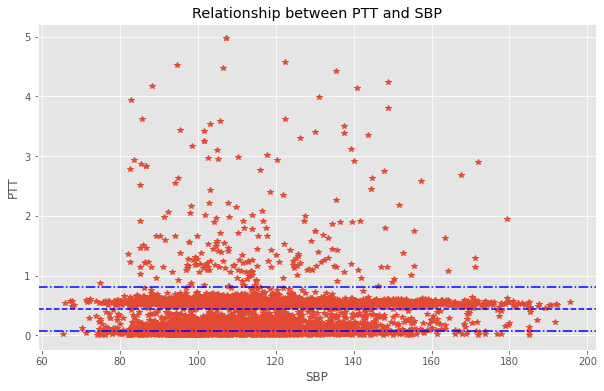

In [41]:
ptt = dataset['ptt']
bpmax = dataset['bpmax']
bpmin = dataset['bpmin']
sort_index = np.argsort(bpmax)

ptt_mu =  np.mean(ptt)
ptt_std = np.std(ptt)

plt.figure(figsize=(10,6))
plt.title('Relationship between PTT and SBP')
plt.plot(bpmax[sort_index], ptt[sort_index], '*')
plt.ylabel('PTT')
plt.xlabel('SBP')
plt.axhline(ptt_mu, c='blue', ls='--')
plt.axhline(ptt_mu- ptt_std, c='blue', ls='-.')
plt.axhline(ptt_mu+ ptt_std, c='blue', ls='-.')


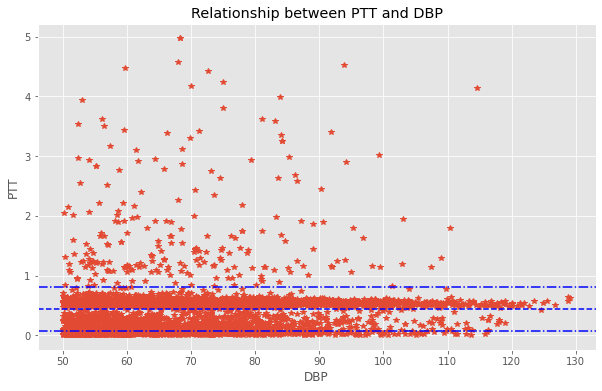

In [42]:
sort_index = np.argsort(bpmin)
plt.figure(figsize=(10,6))
plt.title('Relationship between PTT and DBP')
plt.plot(bpmin[sort_index], ptt[sort_index], '*')
plt.ylabel('PTT')
plt.xlabel('DBP')

plt.axhline(ptt_mu, c='blue', ls='--')
plt.axhline(ptt_mu- ptt_std, c='blue', ls='-.')
plt.axhline(ptt_mu+ ptt_std, c='blue', ls='-.')

In [48]:
pd.DataFrame(vital_sign)

,subject,HR,PHR,PATp
0,shawn_0224_1,80.304673,96.768345,NaN
1,shawn_0224_1,79.970735,84.979736,NaN
2,shawn_0224_1,74.289916,104.049455,0.451172
3,shawn_0224_1,71.131011,70.268175,NaN
4,shawn_0224_1,73.793796,95.493561,0.248047
5,shawn_0224_2,79.424480,88.558063,0.292969
6,shawn_0224_2,80.919169,80.264467,0.197545
7,shawn_0224_2,80.002128,69.290926,0.398438
8,shawn_0224_2,79.037192,86.818436,0.377604
9,shawn_0224_2,84.402400,98.212497,NaN
